In [1]:
%matplotlib inline

from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from ripser import ripser
from persim import plot_diagrams
import networkx as nx

from peyers_utils import color_dict, shape_dict, get_sample_labels_tissue, tissue_list, microbiota_list

In [2]:
counts_M = pd.read_csv("peyers_data/counts_M.csv", index_col=0)
normCounts_M = pd.read_csv("peyers_data/normCounts_M.csv", index_col=0)
md_M = pd.read_csv("peyers_data/md_M.txt", index_col=0,
                  sep="\t")

counts_tissue = pd.read_csv("peyers_data/counts_tissue.csv", index_col=0)
normCounts_tissue = pd.read_csv("peyers_data/normCounts_tissue.csv",
                                index_col=0)
md_tissue = pd.read_csv("peyers_data/md_tissue.txt", index_col=0,
                       sep="\t")

In [3]:
X_M = counts_M.to_numpy().T
X_M_norm = normCounts_M.to_numpy().T
X_tissue = counts_tissue.to_numpy().T
X_tissue_norm = normCounts_tissue.to_numpy().T

logX_M = np.log(X_M + 1)
logX_M_norm = np.log(X_M_norm + 1)
logX_tissue = np.log(X_tissue + 1)
logX_tissue_norm = np.log(X_tissue_norm + 1)

dist_mat_M = euclidean_distances(logX_M)
dist_mat_M_norm = euclidean_distances(logX_M_norm)
dist_mat_tissue = euclidean_distances(logX_tissue)
dist_mat_tissue_norm = euclidean_distances(logX_tissue_norm)

In [4]:
def look_at_homology(dist_mat):
    print("Computing persistent homology...")
    start = time()
    rips_dict = ripser(dist_mat, maxdim=2,
                      distance_matrix=True)
    print("Time elapsed: "+str(time() - start)+" seconds")
    dgms = rips_dict["dgms"]
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    plot_diagrams(dgms, ax=ax)
    
    plt.show()

def get_most_variable_genes(X, p):
    var_vec = np.var(X, axis=0)
    ind_list = list(range(len(var_vec)))
    ind_list.sort(key=lambda x: var_vec[x], reverse=True)
    top_inds = ind_list[:p]
    return top_inds

<h3>Analysis in this notebook will be done with X_tissue_norm</h3>

In [5]:
p = 3000

"""
top_inds_p = get_most_variable_genes(X_M_norm, p)

X_M_norm_p = X_M_norm[:, top_inds_p]
"""

top_inds_p = get_most_variable_genes(X_tissue_norm, p)

X_tissue_norm_p = X_tissue_norm[:, top_inds_p]

Computing persistent homology...
Time elapsed: 0.03258943557739258 seconds


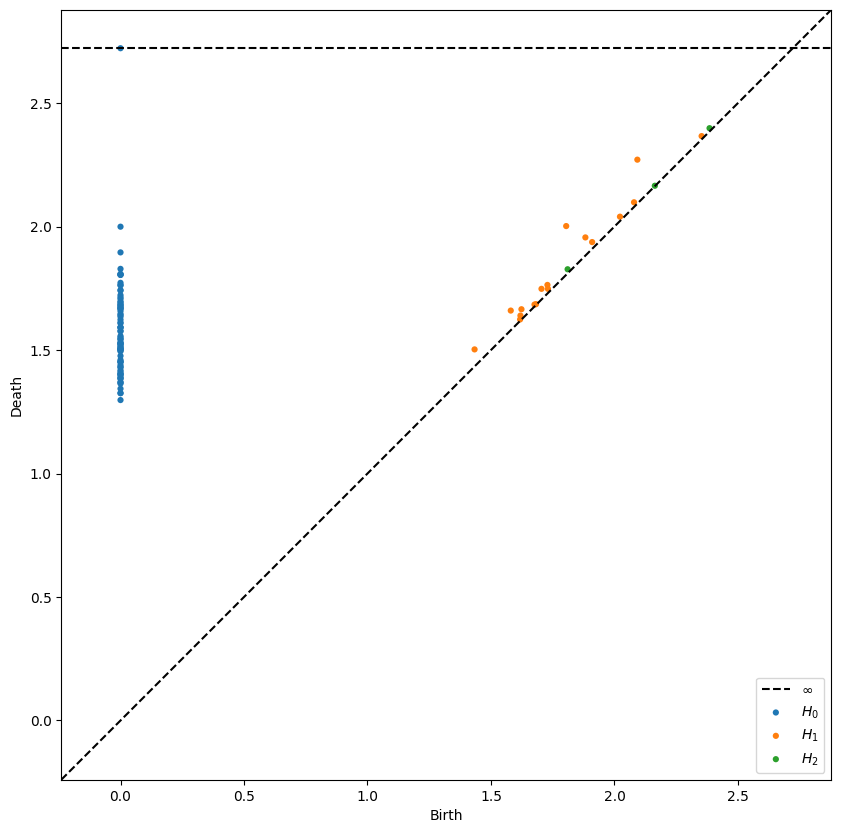

In [6]:
logX_tissue_norm_p = np.log10(X_tissue_norm_p + 1)
dist_mat_p = euclidean_distances(X_tissue_norm_p, X_tissue_norm_p)
dist_mat_log_p = euclidean_distances(logX_tissue_norm_p,
                                     logX_tissue_norm_p)

look_at_homology(dist_mat_log_p)
#look_at_homology(dist_mat_p)

In [7]:
"""
rips_dict = ripser(dist_mat_log_p, maxdim=2,
                   distance_matrix=True,
                  do_cocycles=True)
"""
rips_dict = ripser(dist_mat_p, maxdim=2,
                  distance_matrix=True,
                  do_cocycles=True)
dgms0, dgms1, dgms2 = rips_dict["dgms"]
coc0, coc1, coc2 = rips_dict["cocycles"]

def lifetimes_from_dgms(dgms):
    lt_list = []
    n, _ = dgms.shape
    for j in range(n):
        birth, death = dgms[j, :]
        lt = death - birth
        lt_list.append(lt)
    return lt_list

lts0 = lifetimes_from_dgms(dgms0)
lts1 = lifetimes_from_dgms(dgms1)
lts2 = lifetimes_from_dgms(dgms2)


"""
print(type(dgms1))
print(dgms1.shape)

print("\n\n")

print(type(coc1))
print(len(coc1))

for item in coc1:
    print(item)
"""

'\nprint(type(dgms1))\nprint(dgms1.shape)\n\nprint("\n\n")\n\nprint(type(coc1))\nprint(len(coc1))\n\nfor item in coc1:\n    print(item)\n'

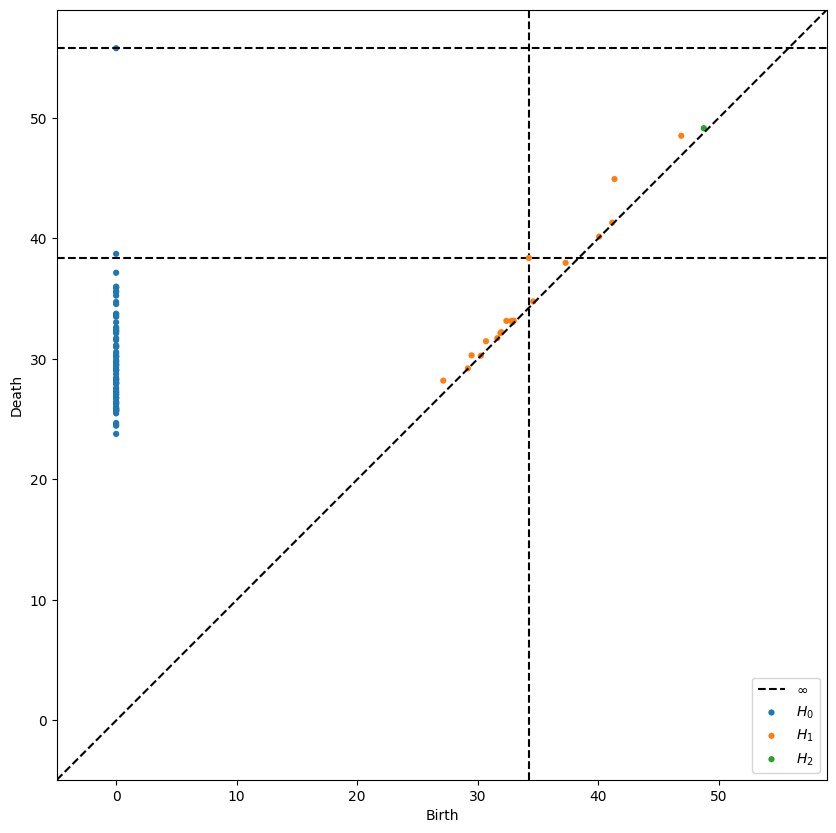

In [8]:
sorted_by_lt = list(range(len(lts1)))
sorted_by_lt.sort(key=lambda x: lts1[x], reverse=True)
ind_0 = sorted_by_lt[0]
ind_v = sorted_by_lt[0]
ind_last = sorted_by_lt[-1]

#foi = np.argmax(lts1)
birth_foi, death_foi = dgms1[ind_v, :]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

plot_diagrams(rips_dict["dgms"], ax=ax)

color = "k"
linestyle = "dashed"
zorder = -10
ax.axvline(birth_foi, color=color, linestyle=linestyle,
          zorder=zorder)
ax.axhline(death_foi, color=color, linestyle=linestyle,
          zorder=zorder)

plt.show()

In [9]:
pca = PCA(n_components=3)
#pca.fit(X_M_norm)
pca.fit(X_tissue_norm)

#Y_M_norm = pca.transform(X_M_norm)
Y_tissue_norm = pca.transform(X_tissue_norm)

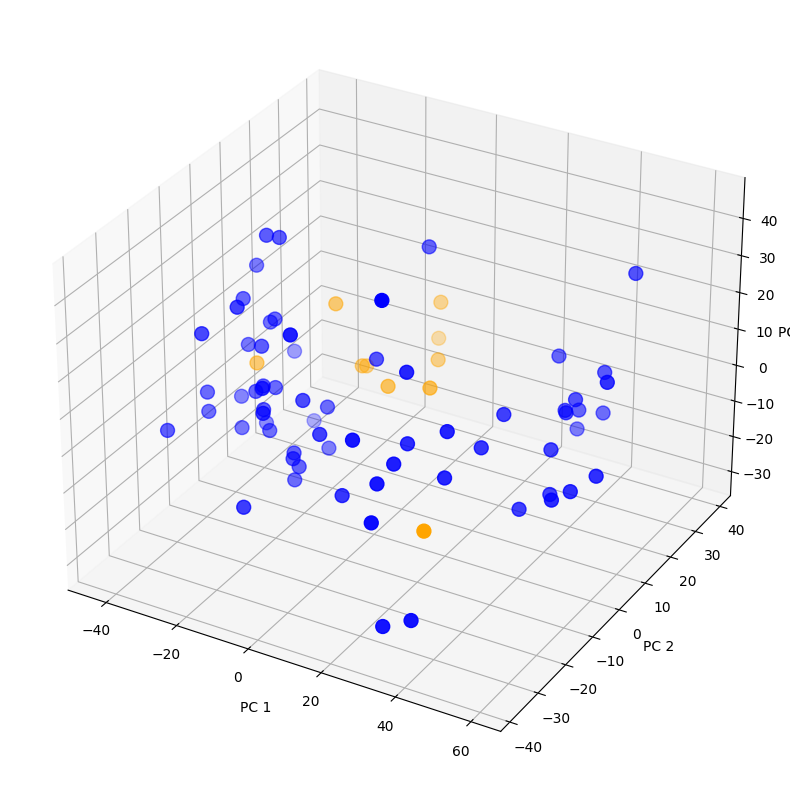

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

coc_foi = coc1[ind_v]
ind_set = set()
for feat in coc_foi:
    for ind in feat:
        ind_set.add(ind)
ind_list = list(ind_set)
ind_list.sort()
Y_tissue_norm_foi = Y_tissue_norm[ind_list, :]
Y_tissue_norm_not_foi = Y_tissue_norm[[ind for ind in range(Y_tissue_norm.shape[0]) if ind not in ind_list], :]

ax.scatter(Y_tissue_norm_not_foi[:, 0], Y_tissue_norm_not_foi[:, 1],
           Y_tissue_norm_not_foi[:, 2], color="b",
           s=100)
ax.scatter(Y_tissue_norm_foi[:, 0], Y_tissue_norm_foi[:, 1],
          Y_tissue_norm_foi[:, 2], color="orange",
          s=100)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

plt.show()

In [11]:
birth_foi, death_foi = dgms1[ind_v, :]

coc1_foi = coc1[ind_v]

print(coc1_foi)

[[77 14  1]
 [76 14  1]
 [76 72  1]
 [26 14  1]
 [14  6  1]
 [76 40  1]
 [76 15  1]
 [42  6  1]]


In [12]:
loi = np.argmin(lts1)
birth_loi, death_loi = dgms1[loi, :]

coc1_loi = coc1[loi]

print(coc1_loi)

[[73 61  1]
 [64 61  1]]


In [13]:
def compute_boundary_map(feat_list):
    d = len(feat_list[0])
    for feat in feat_list:
        assert len(feat) == d
    feat_list_trim = []
    for feat in feat_list:
        if len(np.unique(feat)) == d:
            feat_list_trim.append(feat)
    bound_dict = {}
    for j, feat in enumerate(feat_list_trim):
        bound_list = []
        for k, ind in enumerate(feat):
            bound_list.append([feat[kk] for kk in range(d) if kk != k])
        bound_dict[j] = bound_list
    return feat_list_trim, bound_dict

def boundary_collapse(bound_dict):
    bound_set = set()
    for key, feats in bound_dict.items():
        for feat in feats:
            feat.sort()
            toople = tuple(feat)
            if toople in bound_set:
                bound_set.remove(toople)
            else:
                bound_set.add(toople)
    return bound_set

def path_from_collapsed_boundary(bound_set):
    G = nx.Graph()
    bound_list = list(bound_set)
    # Add nodes
    for feat in bound_list:
        for ind in feat:
            G.add_node(ind)
    # Add edges
    for feat in bound_list:
        u, v = feat
        G.add_edge(u, v)
    # Eulerian path
    path = list(nx.eulerian_circuit(G))
    return path

def draw_path_on_scatter(path, ax):
    for edge in path:
        ind_0, ind_1 = edge
        pt_0 = Y_tissue_norm[ind_0, :]
        pt_1 = Y_tissue_norm[ind_1, :]
        xs = [pt_0[0], pt_1[0]]
        ys = [pt_0[1], pt_1[1]]
        zs = [pt_0[2], pt_1[2]]
        ax.plot(xs, ys, zs, color="k",
               linestyle="dashed")

In [14]:
feat_list_foi, bound_dict_foi = compute_boundary_map(coc1_foi)
feat_list_loi, bound_dict_loi = compute_boundary_map(coc1_loi)

coll_foi = boundary_collapse(bound_dict_foi)
path_foi = path_from_collapsed_boundary(coll_foi)

coll_loi = boundary_collapse(bound_dict_loi)
path_loi = path_from_collapsed_boundary(coll_loi)
print(coll_loi)

{(1, 73), (61, 64), (61, 73), (1, 64)}


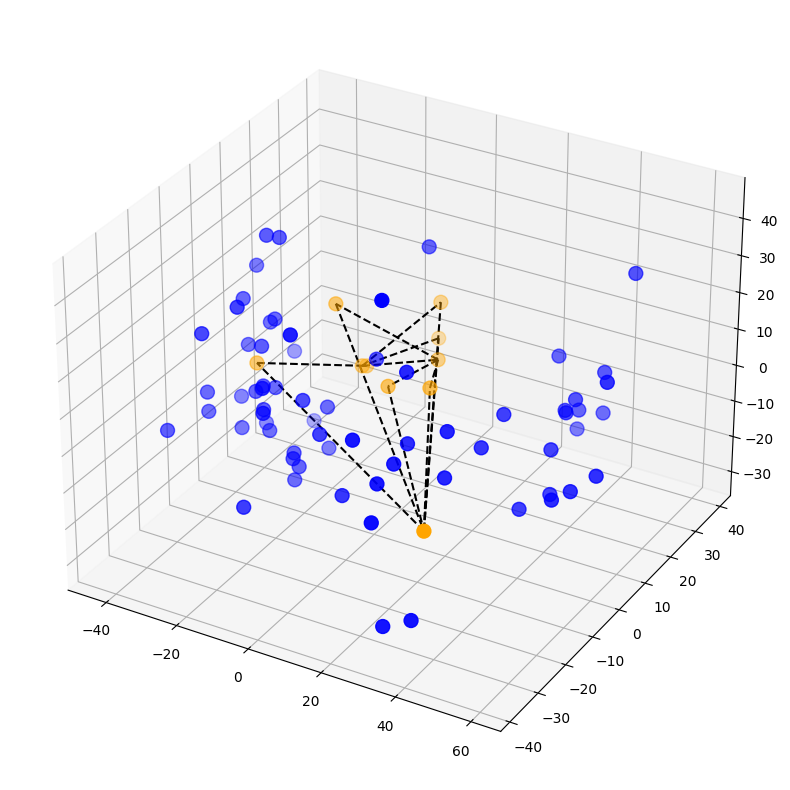

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

coc_foi = coc1[ind_v]
ind_set = set()
for feat in coc_foi:
    for ind in feat:
        ind_set.add(ind)
Y_tissue_norm_foi = Y_tissue_norm[ind_list, :]
Y_tissue_norm_not_foi = Y_tissue_norm[[ind for ind in range(Y_tissue_norm.shape[0]) if ind not in ind_list], :]

ax.scatter(Y_tissue_norm_not_foi[:, 0], Y_tissue_norm_not_foi[:, 1],
           Y_tissue_norm_not_foi[:, 2], color="b",
           s=100)
ax.scatter(Y_tissue_norm_foi[:, 0], Y_tissue_norm_foi[:, 1],
          Y_tissue_norm_foi[:, 2], color="orange",
          s=100)

draw_path_on_scatter(path_foi, ax)

plt.show()

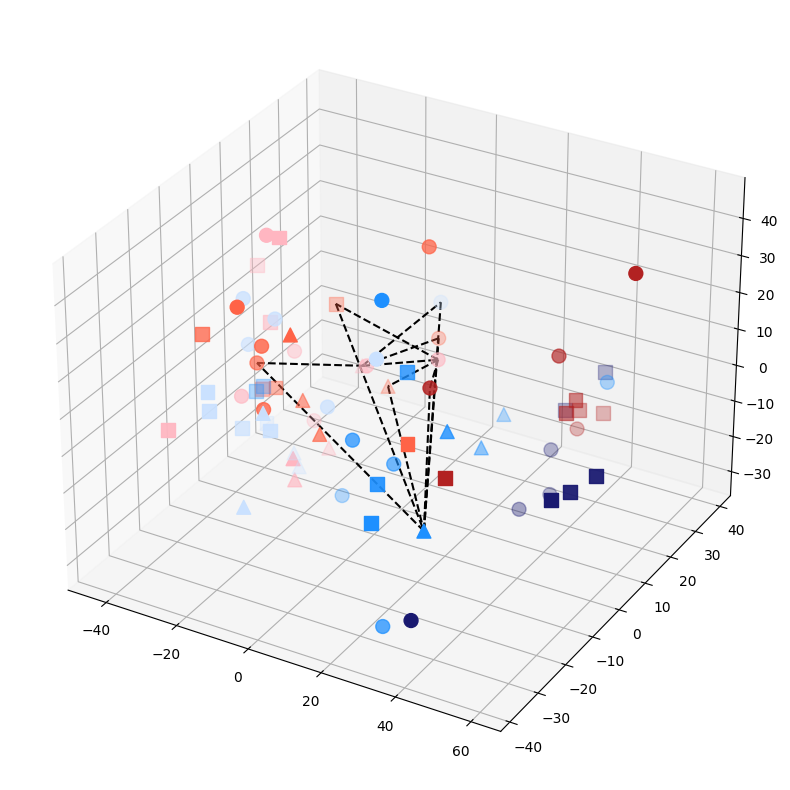

In [21]:
sample_tissue_list, sample_microbiota_list = get_sample_labels_tissue()

sample_group_dict = {}
for tissue in tissue_list:
    for micro in microbiota_list:
        key = (tissue, micro)
        sample_group_dict[key] = np.zeros(78, dtype=bool)

for j, key in enumerate(zip(sample_tissue_list, sample_microbiota_list)):
    sample_group_dict[key][j] = True

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

for tissue in tissue_list:
    for micro in microbiota_list:
        key = (tissue, micro)
        color = color_dict[tissue]
        shape = shape_dict[micro]
        to_keep = sample_group_dict[key]
        Y_kept = Y_tissue_norm[to_keep, :]
        ax.scatter(Y_kept[:, 0], Y_kept[:, 1], Y_kept[:, 2],
                      c=color, marker=shape, s=100)

draw_path_on_scatter(path_foi, ax)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

plt.show()

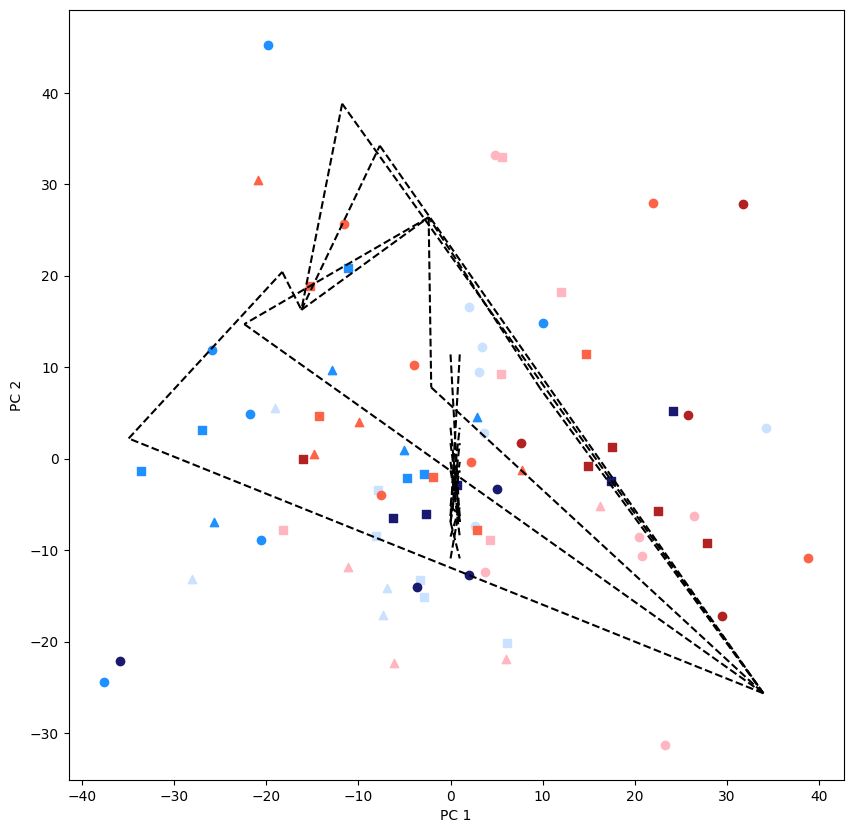

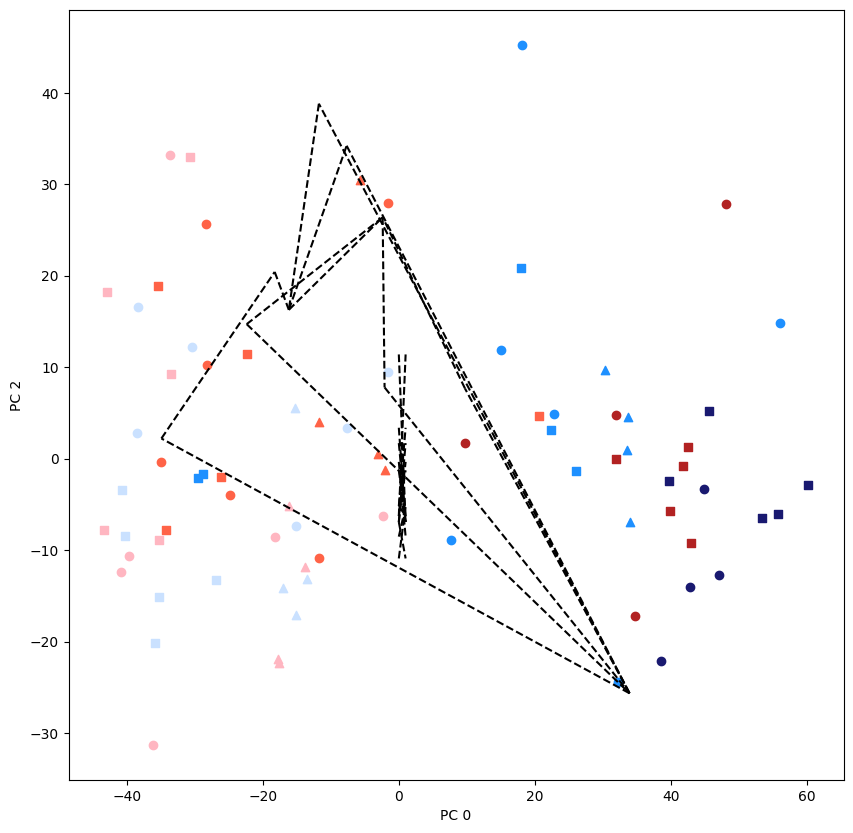

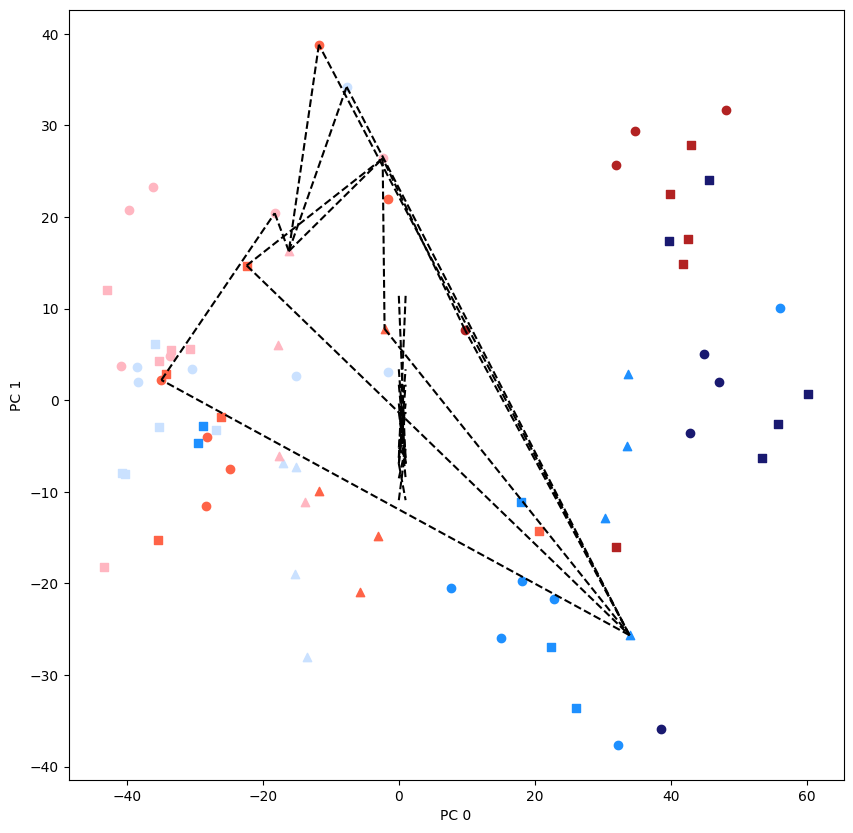

In [25]:
for ind in range(3):
    j, k = [i for i in range(3) if i != ind]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    
    for tissue in tissue_list:
        for micro in microbiota_list:
            key = (tissue, micro)
            color = color_dict[tissue]
            shape = shape_dict[micro]
            to_keep = sample_group_dict[key]
            Y_kept = Y_tissue_norm[to_keep, :]
            ax.scatter(Y_kept[:, j], Y_kept[:, k],
                          c=color, marker=shape)

    draw_path_on_scatter(path_foi, ax)
    ax.set_xlabel("PC " + str(j))
    ax.set_ylabel("PC " + str(k))

plt.show()